In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# zip 파일을 위한 모듈
import os
import io
import zipfile
from zipfile import ZipFile

In [2]:
# open할 데이터 파일
!ls ../data/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# 압축된 파일들의 리스트 확인하기
with ZipFile('../data/open.zip','r') as zipObj:
    listOfFileNames = zipObj.namelist()
    for fileName in listOfFileNames:
        print(fileName)

sample_submission.csv
test.csv
train.csv


In [44]:
# 특정 파일만 압축풀기
with ZipFile('../data/open.zip','r') as zipObj:
    list_filenames = zipObj.namelist()
    for filename in list_filenames:
        if filename in ['train.csv','test.csv']:
            zipObj.extract(filename, '..'+os.path.sep+'data'+os.path.sep)

In [5]:
!ls ../data/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [49]:
train = pd.read_csv('../data/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('../data/test.csv')

In [7]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,10.0,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,10.0,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,30.0,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,10.0,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,20.0,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444


In [19]:
train['BUILT'] = train['BUILT'].astype(float)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SHIP_TYPE_CATEGORY  391939 non-null  int32  
 1   DIST                391939 non-null  float64
 2   BREADTH             391939 non-null  float64
 3   BUILT               391939 non-null  float64
 4   DEADWEIGHT          391939 non-null  int64  
 5   DEPTH               391939 non-null  float64
 6   DRAUGHT             391939 non-null  float64
 7   GT                  391939 non-null  int64  
 8   LENGTH              391939 non-null  float64
 9   U_WIND              391939 non-null  float64
 10  V_WIND              391939 non-null  float64
 11  AIR_TEMPERATURE     391939 non-null  float64
 12  BN                  391939 non-null  float64
 13  ATA_LT              391939 non-null  int64  
 14  PORT_SIZE           391939 non-null  float64
 15  CI_HOUR             391939 non-nul

### Data Pre-Processing
- datetime 컬럼을 여러 파생 변수(연, 월, 일, 시, 분, 요일) 로 변환한다.
- Categorical(범주형) 컬럼을 인코딩한다.

In [11]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
#     df['minute'] = df['ATA'].dt.minute
#     df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

In [12]:
# Categorical 컬럼 인코딩
from sklearn.preprocessing import LabelEncoder
import bisect

categorical_features = ['ARI','SHIP_TYPE_CATEGORY']

le = LabelEncoder()
for df in [train, test]:    
    # ARI_CO + ARI_PO = ARI
    df['ARI']=df['ARI_CO']+df['ARI_PO']
    df.drop(columns=['ARI_CO','ARI_PO'],axis=1,inplace=True)

    # drop useless features
    df.drop(columns=['ID','SHIPMANAGER','FLAG'],axis=1,inplace=True)

    # encode
    for feature in categorical_features:
        df[feature] = le.fit_transform(df[feature].astype(str))
        


In [7]:
# Categorical 컬럼 인코딩
# from sklearn.preprocessing import LabelEncoder
# import bisect
# from tqdm import tqdm

# categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
# encoders = {}

# for feature in tqdm(categorical_features, desc="Encoding features"):
#     le = LabelEncoder()
#     train[feature] = le.fit_transform(train[feature].astype(str))
#     le_classes_set = set(le.classes_)
#     test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
#     le_classes = le.classes_.tolist()
#     bisect.insort_left(le_classes, '-1')
#     le.classes_ = np.array(le_classes)
#     test[feature] = le.transform(test[feature].astype(str))
#     encoders[feature] = le

Encoding features: 100%|████████████████████████████████████████████| 6/6 [00:00<00:00,  7.18it/s]


In [13]:
# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

In [14]:
train

,SHIP_TYPE_CATEGORY,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,...,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR,year,month,day,hour,ARI
0,2,30.881018,30.0,24,24300,10.0,10.0,16700,180.0,-0.29491,...,18.862968,2.706992,5,0.002615,3.450000,2018,12,17,21,90
1,0,0.000000,30.0,13,35900,10.0,10.0,23500,180.0,-0.29491,...,18.862968,2.706992,12,0.000217,0.000000,2014,9,23,6,52
2,2,0.000000,50.0,12,146000,30.0,20.0,140000,370.0,-0.29491,...,18.862968,2.706992,6,0.001614,0.000000,2015,2,3,22,23
3,2,0.000000,20.0,18,6910,10.0,10.0,5400,120.0,-3.18000,...,6.700000,2.629350,13,0.000356,0.000000,2020,1,17,4,66
4,2,27.037650,50.0,10,116000,20.0,10.0,96600,300.0,-0.33000,...,25.600000,2.495953,15,0.002615,253.554444,2020,1,26,7,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,2,0.000000,20.0,27,6820,10.0,10.0,4820,110.0,-0.29491,...,18.862968,2.706992,14,0.000552,0.000000,2017,6,6,5,61
391935,0,5.884603,10.0,12,3160,10.0,10.0,1600,80.0,-0.66000,...,27.300000,1.253491,8,0.002615,144.061389,2019,10,16,0,90
391936,0,70.660241,30.0,8,60300,20.0,10.0,34800,200.0,-3.44000,...,21.100000,4.766257,18,0.000155,41.482222,2021,3,23,22,97
391937,2,9.448179,30.0,29,23800,10.0,10.0,16900,170.0,-0.29491,...,18.862968,2.706992,15,0.000990,7.485278,2015,1,8,7,93


## EDA (Exploratory Data Analysis)

#### 상관분석

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

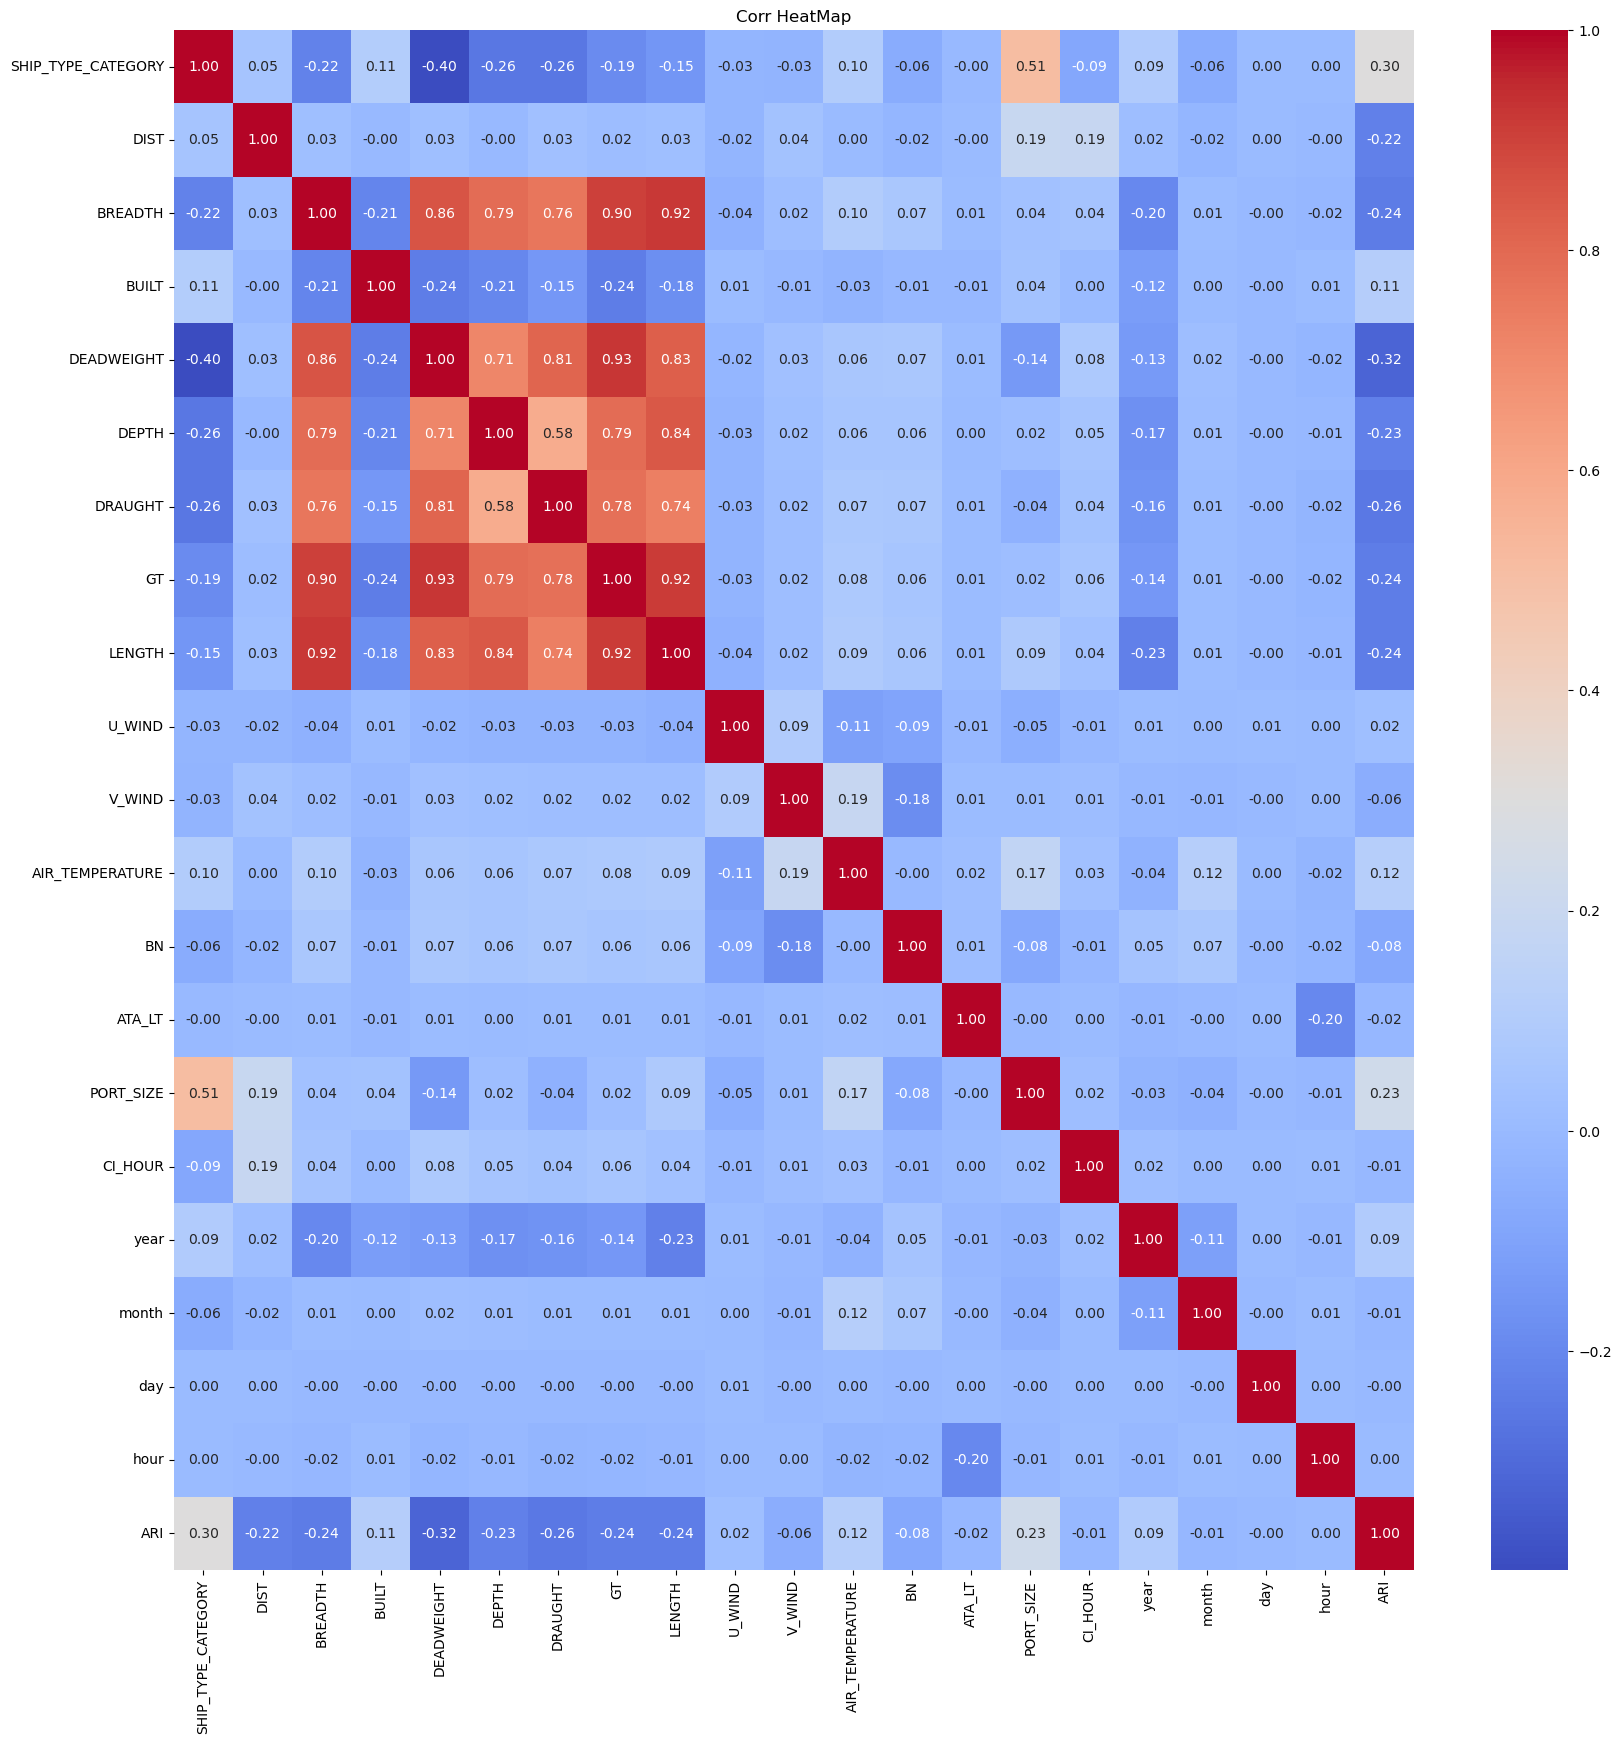

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
# df로부터 '상관계수 행렬'을 구한다.
train_correlation_matrix = train.corr()
# 상관관계를 시각화한다.
plt.figure(figsize=(20, 20))
sns.heatmap(train_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corr HeatMap")
plt.savefig('HD_ship_Corr.png',dpi=300)
plt.show()

In [ ]:
X=train['ARI_CO','ARI_PO','SHIP_TYPE_CATEGORY','DIST','BREADTH','BUILT',]


In [21]:
# 특정 파일만 압축풀기
with ZipFile('../data/open.zip','r') as zipObj:
    list_filenames = zipObj.namelist()
    for filename in list_filenames:
        if filename in ['sample_submission.csv']:
            zipObj.extract(filename, '..'+os.path.sep+'data'+os.path.sep)

In [45]:
sample = pd.read_csv('../data/sample_submission.csv',index_col='SAMPLE_ID')

In [52]:
test = test.set_index(['SAMPLE_ID'])
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220491 entries, TEST_000000 to TEST_220490
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              220491 non-null  object 
 1   ARI_PO              220491 non-null  object 
 2   SHIP_TYPE_CATEGORY  220491 non-null  object 
 3   DIST                220491 non-null  float64
 4   ATA                 220491 non-null  object 
 5   ID                  220491 non-null  object 
 6   BREADTH             220491 non-null  float64
 7   BUILT               220491 non-null  int64  
 8   DEADWEIGHT          220491 non-null  int64  
 9   DEPTH               220491 non-null  float64
 10  DRAUGHT             220491 non-null  float64
 11  GT                  220491 non-null  int64  
 12  LENGTH              220491 non-null  float64
 13  SHIPMANAGER         220491 non-null  object 
 14  FLAG                220491 non-null  object 
 15  U_WIND              1287

In [53]:
list(test.index)

['TEST_000000',
 'TEST_000001',
 'TEST_000002',
 'TEST_000003',
 'TEST_000004',
 'TEST_000005',
 'TEST_000006',
 'TEST_000007',
 'TEST_000008',
 'TEST_000009',
 'TEST_000010',
 'TEST_000011',
 'TEST_000012',
 'TEST_000013',
 'TEST_000014',
 'TEST_000015',
 'TEST_000016',
 'TEST_000017',
 'TEST_000018',
 'TEST_000019',
 'TEST_000020',
 'TEST_000021',
 'TEST_000022',
 'TEST_000023',
 'TEST_000024',
 'TEST_000025',
 'TEST_000026',
 'TEST_000027',
 'TEST_000028',
 'TEST_000029',
 'TEST_000030',
 'TEST_000031',
 'TEST_000032',
 'TEST_000033',
 'TEST_000034',
 'TEST_000035',
 'TEST_000036',
 'TEST_000037',
 'TEST_000038',
 'TEST_000039',
 'TEST_000040',
 'TEST_000041',
 'TEST_000042',
 'TEST_000043',
 'TEST_000044',
 'TEST_000045',
 'TEST_000046',
 'TEST_000047',
 'TEST_000048',
 'TEST_000049',
 'TEST_000050',
 'TEST_000051',
 'TEST_000052',
 'TEST_000053',
 'TEST_000054',
 'TEST_000055',
 'TEST_000056',
 'TEST_000057',
 'TEST_000058',
 'TEST_000059',
 'TEST_000060',
 'TEST_000061',
 'TEST_0

In [25]:
test.isnull().sum()

SHIP_TYPE_CATEGORY    0
DIST                  0
BREADTH               0
BUILT                 0
DEADWEIGHT            0
DEPTH                 0
DRAUGHT               0
GT                    0
LENGTH                0
U_WIND                0
V_WIND                0
AIR_TEMPERATURE       0
BN                    0
ATA_LT                0
PORT_SIZE             0
year                  0
month                 0
day                   0
hour                  0
ARI                   0
dtype: int64

In [34]:
test.loc[6,['U_WIND','V_WIND']]

U_WIND    9.86
V_WIND    5.63
Name: 6, dtype: float64